Tasks:
* Create cronjob
* Web scrapping
* Download zip file
* Unzip it
* Read file which name start with "lotto_"

Preparation:
* Read file
* Extract columns 'boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'numero_chance', year
* Set custom range of rows (slider or input), predefine ranges - last 50, all, etc.

Analysis:
* Odd / Even - (3 odd + 2 even - 814 times)
* Define patterns: (1-9 - blue, 10-19 - yellow, etc) occurencies (by year) count and PROBABILITY https://lottometrix.com/members/analysis-euromillions.php
* Top Hot - most occurencies in row range
* Top Cold - less occurencies on row range
* Overdue - Number which isn't drawn for a long time (show be beyond range)
* Pairs and frequency (2,14 - 5 times)
* Sum and frequency (sum of all numbers: 132 - 56 times)
* Low / High - split on 24(or 25) occurencies - (3 low, 2 high - 529 times)
* Consecutives (0 - 1144 times, 1 - 311 times)
* Regularity (each number is + 7) or (+7 +8 + 9 etc)
* Following numbers
* Non following numbers
* Average numbers
* Heat map chart

AI:
* Split analysis on two groups: probability and history. Set each of them value. History value should be lesser than prob one

In [ ]:
%pip install -q pandas
%pip install -q seaborn 
%pip install -q matplotlib
%pip install -q requests
%pip install -q joblib
%pip install -q scikit-learn

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [135]:
# ENVIRONMENTS SETUP (local to notebook)
ENVIRONMENTS = {
    "fdj": {
        "url_to_zip": "https://media.fdj.fr/static-draws/csv/loto/loto_201911.zip",
        "file_name": "loto_201911.csv",
        "max_number": 49,  # None means all rows
    },
    "em": {
        "url_to_zip": "https://media.fdj.fr/static-draws/csv/euromillions/euromillions_202002.zip",
        "file_name": "euromillions_202002.csv",
        "max_number": 50,
    },

}

# Select environment
ENV = "em"  # Change to "test" or other as needed
config = ENVIRONMENTS[ENV]
url_to_zip = config["url_to_zip"]
file_name = config["file_name"]
max_number = config["max_number"]

In [136]:
# Web scrapping
import requests
import zipfile
import os

def download_and_extract_zip(url, destination_folder):
    # Step 1: Download the zip file
    response = requests.get(url)
    
    if response.status_code == 404:
        print("Failed to download the file. HTTP status code: 404")
        return
    elif response.status_code == 200:
        # Step 2: Save the zip file locally
        zip_filename = "downloaded_file.zip"
        with open(zip_filename, 'wb') as f:
            f.write(response.content)

        # Step 3: Extract the contents of the zip file
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)

        # Step 4: Delete the zip file
        os.remove(zip_filename)
        print(f"Downloaded and extracted successfully to {destination_folder}")
    else:
        print(f"Failed to download the file. HTTP status code: {response.status_code}")

# Example usage
download_and_extract_zip(url_to_zip, "./")

Downloaded and extracted successfully to ./


In [137]:
# Create a DataFrame with all possible numbers from 1 to 49 inclusive
all_numbers = pd.DataFrame({'number': range(1, max_number + 1)})

In [138]:
print(file_name)
try:
    df = pd.read_csv(file_name, sep=";", encoding="utf-8")
except UnicodeDecodeError:
    # Try with a common alternative encoding for French/Euro files
    df = pd.read_csv(file_name, sep=";", encoding="latin1")

euromillions_202002.csv


In [140]:
if ENV == "fdj":
    df = df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'numero_chance', 'date_de_tirage']]
else:
    df = df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'date_de_tirage']]

In [12]:
df.head(20)

,boule_1,boule_2,boule_3,boule_4,boule_5,numero_chance,date_de_tirage
0,32,26,2,5,44,10,25/06/2025
1,20,42,38,44,25,10,23/06/2025
2,34,25,49,18,20,2,21/06/2025
3,9,36,13,24,19,3,18/06/2025
4,1,2,13,39,4,1,16/06/2025
5,25,21,31,44,16,8,14/06/2025
6,9,19,7,18,15,6,11/06/2025
7,25,38,5,34,12,10,09/06/2025
8,7,30,40,37,45,1,07/06/2025
9,2,45,41,18,38,8,04/06/2025


In [141]:
if ENV == "fdj":
    range_col = df['numero_chance']

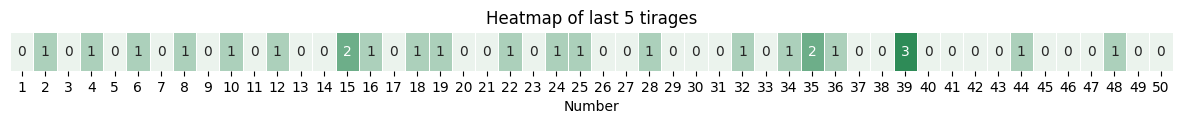

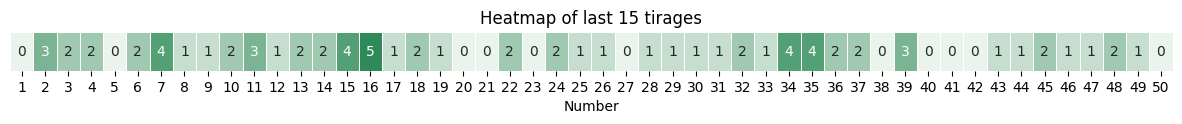

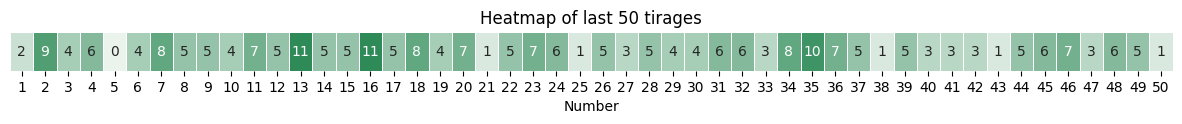

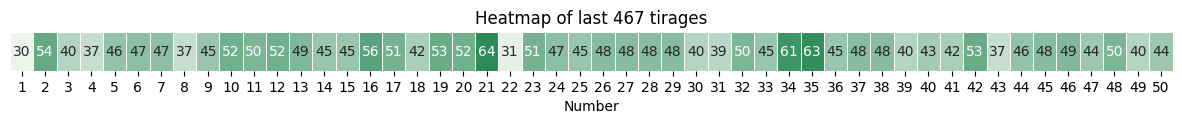

In [143]:
# HEATMAP
def extract_data_frame(data_frame, first_n_rows=None):
    """
    Returns a copy of the first_n_rows of the DataFrame, or the whole DataFrame if first_n_rows is None.
    """
    if first_n_rows is None:
        return data_frame.copy() # Return a copy of the entire DataFrame
    return data_frame.iloc[:first_n_rows].copy() # starts from 0

def show_heat_map(last_tirages=None):
    """
    Displays a heatmap of the frequency of each number (1-49) in the last `last_tirages` draws.
    If last_tirages is None, uses all available draws.
    """
    extracted_df = extract_data_frame(df, last_tirages)
    boule_cols = ['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']
    flat_df = extracted_df.melt(value_vars=boule_cols, var_name='boule', value_name='number')

    tirages_count = len(extracted_df)

    # Count occurrences of each number
    number_counts = flat_df['number'].value_counts().reindex(range(1, max_number+1), fill_value=0).sort_index()

    plt.figure(figsize=(15, 0.5))
    sns.heatmap(
        np.array(number_counts.values).reshape(1, -1),
        cmap=sns.light_palette("seagreen", as_cmap=True),
        annot=True,
        fmt='d',
        linewidths=.5,
        cbar=False,
        xticklabels=[str(x) for x in number_counts.index]
    )
    plt.title(f'Heatmap of last {tirages_count} tirages')
    plt.yticks([])  # Hide y-axis ticks
    plt.xlabel('Number')
    # Remove plt.tight_layout() to avoid the warning about tight layout not being applied
    plt.show()

# Example usage
for n in [5, 15, 50, None]:
    show_heat_map(n)

In [144]:
# PATTERNS

# Select only the boule columns (and optionally the date)
boule_cols = ['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']
dfp = df[boule_cols].copy()

# Sort the values within each row in ascending order efficiently
sorted_df = dfp.apply(lambda row: sorted(row), axis=1, result_type='expand')
sorted_df.columns = boule_cols

# Define a vectorized function to categorize numbers
def categorize_number_vec(numbers):
    bins = [0, 10, 20, 30, 40, max_number]
    labels = ['green', 'yellow', 'red', 'purple', 'blue']
    return pd.cut(numbers, bins=bins, labels=labels, right=True, include_lowest=True).astype(str)

# Apply the categorization function to the DataFrame
categorized_df = sorted_df.apply(categorize_number_vec)

# Create a 'Pattern' column by joining the color categories for each row
categorized_df['Pattern'] = categorized_df.apply(lambda row: '-'.join(row.values), axis=1)

# Display the first 20 rows
print(categorized_df.head(20))

# Count occurrences of each unique pattern
pattern_counts = pd.Series(categorized_df['Pattern']).value_counts()

# Show the 'Pattern' column for the first 20 rows
first_n_counts = pd.Series(categorized_df['Pattern']).head(20)
print(first_n_counts)

# Display the pattern counts
print(pattern_counts)

   boule_1 boule_2 boule_3 boule_4 boule_5                            Pattern
0    green   green   green  yellow  purple    green-green-green-yellow-purple
1   yellow     red  purple    blue    blue        yellow-red-purple-blue-blue
2    green  purple  purple  purple  purple  green-purple-purple-purple-purple
3   yellow  yellow     red     red  purple       yellow-yellow-red-red-purple
4    green  yellow  yellow     red  purple     green-yellow-yellow-red-purple
5   yellow  yellow     red  purple    blue      yellow-yellow-red-purple-blue
6    green   green  purple  purple    blue     green-green-purple-purple-blue
7    green  yellow  yellow     red  purple     green-yellow-yellow-red-purple
8   yellow  yellow  purple    blue    blue     yellow-yellow-purple-blue-blue
9    green   green   green  yellow  yellow    green-green-green-yellow-yellow
10   green  yellow  purple  purple  purple  green-yellow-purple-purple-purple
11   green  yellow  yellow     red  purple     green-yellow-yell

Legend:


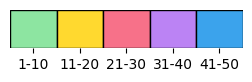

In [145]:
"""
Legend for Color Categories:

This function displays a legend mapping color codes to number ranges used in pattern visualizations.

- Green  (#8de5a1): 1-10
- Yellow (#ffd92f): 11-20
- Red    (#f77189): 21-30
- Purple (#bb83f4): 31-40
- Blue   (#3ba3ec): 41-max_number

Usage:
    plot_legend()
"""

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_legend():
    """
    Display a legend for the color-coded number ranges used in pattern visualizations.

    Color mapping:
        - 1-10   : green  (#8de5a1)
        - 11-20  : yellow (#ffd92f)
        - 21-30  : red    (#f77189)
        - 31-40  : purple (#bb83f4)
        - 41-max_number  : blue   (#3ba3ec)
    """
    colors = ['#8de5a1', '#ffd92f', '#f77189', '#bb83f4', '#3ba3ec']
    labels = ['1-10', '11-20', '21-30', '31-40', f'41-{max_number}']
    num_rectangles = len(colors)
    width, height = 1.0, 1.0

    fig, ax = plt.subplots(figsize=(3, 0.5))
    for i, (color, label) in enumerate(zip(colors, labels)):
        rect = patches.Rectangle((i * width, 0), width, height, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

    ax.set_xticks([width * i + width / 2 for i in range(num_rectangles)])
    ax.set_xticklabels(labels)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlim(0, num_rectangles * width)
    ax.set_ylim(0, height)
    plt.box(False)
    print("Legend:")
    plt.show()

plot_legend()

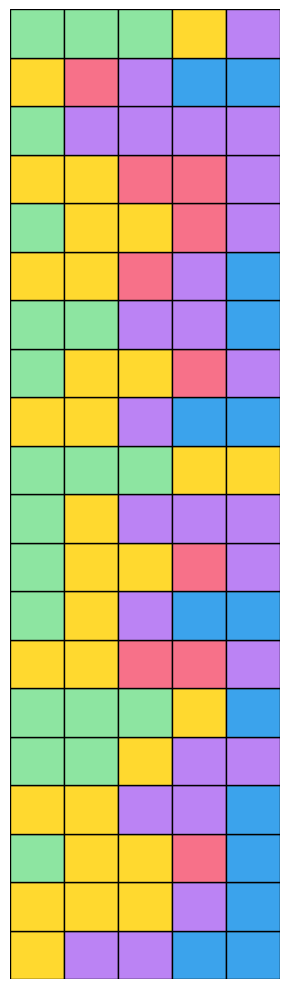

In [146]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

class PatternPlotter:
    """
    Visualizes lottery draw patterns as color-coded rectangles.

    Each row in the DataFrame should have a 'Pattern' column with color names
    separated by '-', e.g., 'green-yellow-red-purple-blue'.

    Attributes:
        df (pd.DataFrame): DataFrame containing the 'Pattern' column.
        color_mapping (dict): Maps color names to indices.
        colors (list): List of hex color codes corresponding to color_mapping.
    """
    def __init__(self, df):
        self.df = df
        self.color_mapping = {'green': 0, 'yellow': 1, 'red': 2, 'purple': 3, 'blue': 4}
        self.colors = ['#8de5a1', '#ffd92f', '#f77189', '#bb83f4', '#3ba3ec']

    def plot_patterns(self):
        """
        Plots the patterns as rows of colored rectangles.
        Each row represents a draw, and each rectangle a number's color category.
        """
        n_rows = len(self.df)
        if n_rows == 0:
            print("No data to plot.")
            return

        # Get number of pattern elements from the first row
        pattern_colors = self.df.iloc[0]['Pattern'].split('-')
        n_cols = len(pattern_colors)

        fig, ax = plt.subplots(figsize=(3, max(1, n_rows / 2)))

        # Iterate in reverse to show most recent at the top
        for plot_idx, (_, row) in enumerate(self.df.iloc[::-1].iterrows()):
            pattern_colors = row['Pattern'].split('-')
            for i, color in enumerate(pattern_colors):
                color_idx = self.color_mapping.get(color, None)
                if color_idx is not None:
                    rect = patches.Rectangle(
                        (i, plot_idx), 1, 1,
                        edgecolor='black',
                        facecolor=self.colors[color_idx]
                    )
                    ax.add_patch(rect)
                else:
                    # If color not found, fill with gray
                    rect = patches.Rectangle(
                        (i, plot_idx), 1, 1,
                        edgecolor='black',
                        facecolor='#cccccc'
                    )
                    ax.add_patch(rect)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim(0, n_cols)
        ax.set_ylim(0, n_rows)
        plt.box(False)
        plt.tight_layout()
        plt.show()

# Example usage:
# 'first_n_counts' should be a list of pattern strings, e.g.:
# first_n_counts = ['green-yellow-red-purple-blue', ...]
data = {
    'Pattern': first_n_counts
}
df = pd.DataFrame(data)
PatternPlotter(df).plot_patterns()

Test Set Accuracy: 0.4489
Predicted pattern for next draw:


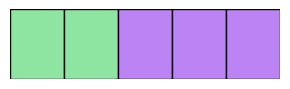

In [147]:
"""
This section trains a Decision Tree Classifier to predict the next lottery pattern
based on historical color patterns. It encodes color names to integers, splits the data,
trains the model, evaluates accuracy, and predicts the next pattern.
"""

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import joblib
import numpy as np
import pandas as pd

# Map color names to integer codes for model input
COLOR_MAPPING = {'green': 0, 'yellow': 1, 'red': 2, 'purple': 3, 'blue': 4}
REVERSE_COLOR_MAPPING = {v: k for k, v in COLOR_MAPPING.items()}

def encode_pattern(pattern_str, color_mapping):
    """Convert a pattern string to a list of integer codes."""
    return [color_mapping[color] for color in pattern_str.split('-')]

def decode_pattern(encoded_pattern, reverse_mapping):
    """Convert a list of integer codes back to a pattern string."""
    return '-'.join([reverse_mapping[int(x)] for x in encoded_pattern])

# Prepare DataFrame from categorized patterns
data = {
    'Pattern': categorized_df['Pattern']
}
df = pd.DataFrame(data)

# Encode patterns as lists of integers
df['PatternEncoded'] = df['Pattern'].apply(lambda x: encode_pattern(x, COLOR_MAPPING))

# Prepare features (X) and targets (y) for supervised learning
# X: all but last pattern, y: next pattern (shifted up by 1)
X = df['PatternEncoded'].iloc[:-1].tolist()
y = df['PatternEncoded'].shift(-1).dropna().tolist()

# Split into training and test sets for evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Decision Tree Classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Save the trained model for future use
joblib.dump(clf, 'pattern-oracle.joblib')
# To load: clf = joblib.load('pattern-oracle.joblib')

# Evaluate model on test set
y_pred_test = clf.predict(X_test)

# Flatten lists for accuracy calculation
y_pred_test_flat = [item for sublist in y_pred_test for item in sublist]
y_test_flat = [item for sublist in y_test for item in sublist]

accuracy = accuracy_score(y_test_flat, y_pred_test_flat)
print(f'Test Set Accuracy: {accuracy:.4f}')

# Predict the next pattern based on the most recent pattern
first_row_features = np.array(df['PatternEncoded'].iloc[0]).reshape(1, -1)
predicted_pattern = clf.predict(first_row_features)[0]
predicted_pattern_str = decode_pattern(predicted_pattern, REVERSE_COLOR_MAPPING)

print("Predicted pattern for next draw:")
# Visualize the predicted pattern
predicted_df = pd.DataFrame({'Pattern': [predicted_pattern_str]})
plotter = PatternPlotter(predicted_df)
plotter.plot_patterns()